In [1]:
# ### mount on google drive if you use colab.
# from google.colab import drive
# drive.mount('/content/drive/')
# import os
# os.chdir("/content/drive/My Drive/WatNet/notebooks")


In [2]:
import os
os.chdir('..')
import glob
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from notebooks import config
import matplotlib.pyplot as plt
from dataloader.img_aug import img_aug
from utils.imgShow import imgShow, imsShow
from model.seg_model.watnet import watnet
from model.seg_model.deeplabv3_plus import deeplabv3_plus
from model.seg_model.deepwatermapv2 import deepwatermapv2
from dataloader.tfrecord_io import parse_image,parse_shape,toPatchPair


## Data loading
### _Load and parse the tfrecord data_

In [3]:
### data loading from .tfrecord file
path_tra_data_scene = 'data/tfrecord-s2/tra_scene.tfrecords'
path_val_data_scene = 'data/tfrecord-s2/val_scene.tfrecords'
path_val_data_patch = 'data/tfrecord-s2/val_patch.tfrecords'
## training data
# tra_dset = tf.data.TFRecordDataset(path_tra_data_scene)  # train/val training
tra_dset = tf.data.TFRecordDataset([path_tra_data_scene, path_val_data_scene]) # final training

tra_dset = tra_dset.map(parse_image).map(parse_shape)\
            .cache()\
            .map(toPatchPair)\
            .map(img_aug)
tra_dset = tra_dset.shuffle(config.buffer_size).batch(config.batch_size)

## validation data
val_dset = tf.data.TFRecordDataset(path_val_data_patch)
val_dset = val_dset.map(parse_image).map(parse_shape)\
            .map(toPatchPair)\
            .cache()

val_dset = val_dset.batch(16)


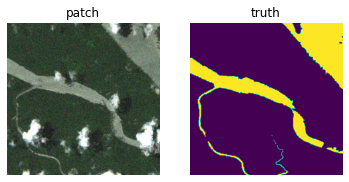

num of scenes: 95
time: 5.229022264480591


In [4]:
## check
# for i in range(5):
start = time.time()
i_batch = i_scene = 0
for patch, truth in tra_dset:
    i_batch += 1
    i_scene += patch.shape[0]
imsShow(img_list=[patch[0], truth[0]], 
        img_name_list=['patch', 'truth'],
        clip_list=[2,0])

plt.show()
print('num of scenes:', i_scene)
print('time:', time.time()-start)


In [5]:
## model configuration
model = watnet(input_shape=(config.patch_size, config.patch_size, config.num_bands), nclasses=2)
# model = deeplabv3_plus(nclasses=2, input_shape=(config.patch_size, config.patch_size, config.num_bands))
# model = deepwatermapv2(min_width=4)



*** Building watnet network ***
*** Output_Shape => (None, 512, 512, 1) ***


In [6]:
'''------1. train step------'''
@tf.function
def train_step(model, loss_fun, optimizer, x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=True)
        loss = loss_fun(y, y_pre)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    config.tra_loss.update_state(loss)
    config.tra_oa.update_state(y, y_pre)
    config.tra_miou.update_state(y, y_pre)
    return config.tra_loss.result(), config.tra_oa.result(), config.tra_miou.result()

'''------2. test step------'''
@tf.function
def test_step(model, loss_fun, x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=False)
        loss = loss_fun(y, y_pre)
    config.val_loss.update_state(loss) 
    config.val_oa.update_state(y, y_pre)
    config.val_miou.update_state(y, y_pre)
    return config.val_loss.result(), config.val_oa.result(), config.val_miou.result()

'''------3. train loops------'''
def train_loops(model, loss_fun, optimizer, tra_dset, val_dset, epochs):
    miou_plot, loss_plot = [], []
    for epoch in range(epochs):
        start = time.time()
        ###--- train the model ---
        for x_batch, y_batch in tra_dset:
            tra_loss_epoch, tra_oa_epoch,tra_miou_epoch = train_step(model, loss_fun, optimizer, x_batch, y_batch)
        ### --- test the model ---
        # if epoch == 0 or epoch>200:
        for x_batch, y_batch in val_dset:
            val_loss_epoch, val_oa_epoch, val_miou_epoch = test_step(model, loss_fun, x_batch, y_batch)
        ### --- update the metrics ---
        config.tra_loss.reset_states(), config.tra_oa.reset_states(), config.tra_miou.reset_states()
        config.val_loss.reset_states(), config.val_oa.reset_states(), config.val_miou.reset_states()
        format = 'Ep {}/{}: traLoss:{:.3f},traOA:{:.3f},traMIoU:{:.3f},valLoss:{:.3f},valOA:{:.3f},valMIoU:{:.3f},time:{:.1f}s'
        print(format.format(epoch + 1, config.epochs, tra_loss_epoch, tra_oa_epoch, tra_miou_epoch, val_loss_epoch, val_oa_epoch, val_miou_epoch, time.time() - start))
        miou_plot.append(val_miou_epoch.numpy())
        loss_plot.append(val_loss_epoch.numpy())
        ## --- visualize the results ---
        if epoch%10 == 0:
            i = np.random.randint(16)
            for val_patch, val_truth in val_dset.take(1):
                plt.figure(figsize=(10,4))
                pre = model(val_patch, training=False)
                imsShow(img_list=[val_patch.numpy()[i], val_truth.numpy()[i], pre.numpy()[i]], \
                        img_name_list=['val_patch', 'val_truth', 'prediction'], \
                        clip_list=[2,0,0],\
                        color_bands_list=None)
                plt.show()
    
    return miou_plot, loss_plot


Ep 1/200: traLoss:0.255,traOA:0.900,traMIoU:0.766,valLoss:0.870,valOA:0.760,valMIoU:0.380,time:22.8s


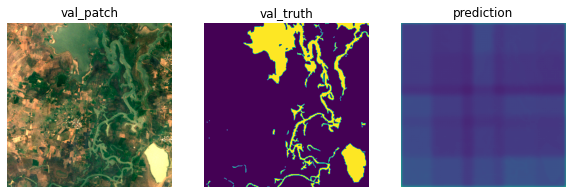

Ep 2/200: traLoss:0.146,traOA:0.949,traMIoU:0.867,valLoss:0.578,valOA:0.734,valMIoU:0.396,time:9.8s
Ep 3/200: traLoss:0.144,traOA:0.945,traMIoU:0.866,valLoss:0.605,valOA:0.760,valMIoU:0.380,time:9.9s
Ep 4/200: traLoss:0.136,traOA:0.950,traMIoU:0.872,valLoss:0.773,valOA:0.760,valMIoU:0.380,time:9.8s
Ep 5/200: traLoss:0.114,traOA:0.958,traMIoU:0.890,valLoss:0.890,valOA:0.760,valMIoU:0.380,time:9.8s
Ep 6/200: traLoss:0.109,traOA:0.960,traMIoU:0.901,valLoss:0.969,valOA:0.760,valMIoU:0.380,time:9.9s
Ep 7/200: traLoss:0.133,traOA:0.953,traMIoU:0.883,valLoss:0.968,valOA:0.760,valMIoU:0.380,time:9.7s
Ep 8/200: traLoss:0.099,traOA:0.965,traMIoU:0.905,valLoss:1.206,valOA:0.760,valMIoU:0.380,time:9.5s
Ep 9/200: traLoss:0.106,traOA:0.960,traMIoU:0.904,valLoss:1.229,valOA:0.760,valMIoU:0.380,time:9.7s
Ep 10/200: traLoss:0.121,traOA:0.956,traMIoU:0.890,valLoss:1.231,valOA:0.760,valMIoU:0.380,time:9.9s
Ep 11/200: traLoss:0.105,traOA:0.962,traMIoU:0.902,valLoss:1.308,valOA:0.760,valMIoU:0.380,time:9.7

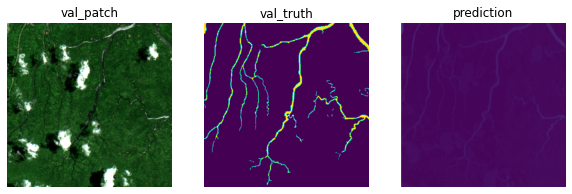

Ep 12/200: traLoss:0.121,traOA:0.957,traMIoU:0.891,valLoss:0.697,valOA:0.763,valMIoU:0.387,time:9.7s
Ep 13/200: traLoss:0.128,traOA:0.955,traMIoU:0.894,valLoss:0.990,valOA:0.764,valMIoU:0.390,time:9.8s
Ep 14/200: traLoss:0.111,traOA:0.954,traMIoU:0.880,valLoss:0.607,valOA:0.771,valMIoU:0.410,time:9.8s
Ep 15/200: traLoss:0.114,traOA:0.957,traMIoU:0.896,valLoss:0.335,valOA:0.836,valMIoU:0.570,time:10.0s
Ep 16/200: traLoss:0.098,traOA:0.964,traMIoU:0.906,valLoss:0.276,valOA:0.851,valMIoU:0.610,time:10.0s
Ep 17/200: traLoss:0.125,traOA:0.953,traMIoU:0.884,valLoss:0.379,valOA:0.805,valMIoU:0.492,time:9.9s
Ep 18/200: traLoss:0.128,traOA:0.950,traMIoU:0.876,valLoss:0.114,valOA:0.969,valMIoU:0.915,time:10.0s
Ep 19/200: traLoss:0.097,traOA:0.963,traMIoU:0.905,valLoss:0.105,valOA:0.968,valMIoU:0.912,time:10.0s
Ep 20/200: traLoss:0.089,traOA:0.967,traMIoU:0.917,valLoss:0.169,valOA:0.928,valMIoU:0.808,time:9.8s
Ep 21/200: traLoss:0.102,traOA:0.962,traMIoU:0.904,valLoss:0.197,valOA:0.880,valMIoU:0.

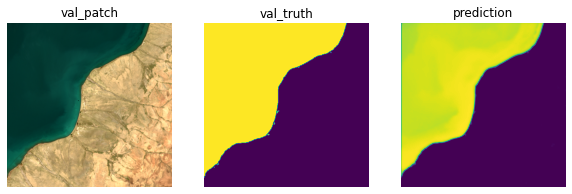

Ep 22/200: traLoss:0.101,traOA:0.960,traMIoU:0.899,valLoss:0.067,valOA:0.985,valMIoU:0.959,time:10.2s
Ep 23/200: traLoss:0.107,traOA:0.959,traMIoU:0.898,valLoss:0.060,valOA:0.985,valMIoU:0.959,time:9.7s
Ep 24/200: traLoss:0.104,traOA:0.958,traMIoU:0.896,valLoss:0.074,valOA:0.985,valMIoU:0.959,time:9.9s
Ep 25/200: traLoss:0.116,traOA:0.954,traMIoU:0.889,valLoss:0.083,valOA:0.979,valMIoU:0.943,time:9.9s
Ep 26/200: traLoss:0.085,traOA:0.971,traMIoU:0.922,valLoss:0.072,valOA:0.983,valMIoU:0.954,time:9.9s
Ep 27/200: traLoss:0.086,traOA:0.969,traMIoU:0.921,valLoss:0.073,valOA:0.975,valMIoU:0.932,time:9.8s
Ep 28/200: traLoss:0.091,traOA:0.967,traMIoU:0.913,valLoss:0.142,valOA:0.969,valMIoU:0.917,time:10.0s
Ep 29/200: traLoss:0.086,traOA:0.970,traMIoU:0.922,valLoss:0.209,valOA:0.971,valMIoU:0.921,time:9.9s
Ep 30/200: traLoss:0.066,traOA:0.975,traMIoU:0.933,valLoss:0.168,valOA:0.973,valMIoU:0.928,time:9.7s
Ep 31/200: traLoss:0.089,traOA:0.967,traMIoU:0.913,valLoss:0.073,valOA:0.981,valMIoU:0.95

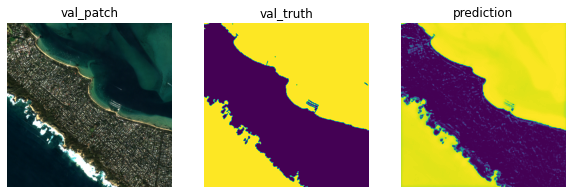

Ep 32/200: traLoss:0.082,traOA:0.969,traMIoU:0.921,valLoss:0.054,valOA:0.980,valMIoU:0.947,time:9.8s
Ep 33/200: traLoss:0.113,traOA:0.952,traMIoU:0.879,valLoss:0.050,valOA:0.981,valMIoU:0.950,time:9.8s
Ep 34/200: traLoss:0.093,traOA:0.963,traMIoU:0.907,valLoss:0.075,valOA:0.976,valMIoU:0.939,time:9.9s
Ep 35/200: traLoss:0.081,traOA:0.971,traMIoU:0.921,valLoss:0.056,valOA:0.978,valMIoU:0.943,time:10.0s
Ep 36/200: traLoss:0.076,traOA:0.973,traMIoU:0.927,valLoss:0.091,valOA:0.978,valMIoU:0.941,time:10.1s
Ep 37/200: traLoss:0.075,traOA:0.973,traMIoU:0.929,valLoss:0.128,valOA:0.977,valMIoU:0.939,time:9.9s
Ep 38/200: traLoss:0.063,traOA:0.978,traMIoU:0.943,valLoss:0.168,valOA:0.962,valMIoU:0.898,time:9.8s
Ep 39/200: traLoss:0.072,traOA:0.973,traMIoU:0.927,valLoss:0.057,valOA:0.985,valMIoU:0.959,time:10.0s
Ep 40/200: traLoss:0.072,traOA:0.974,traMIoU:0.931,valLoss:0.060,valOA:0.979,valMIoU:0.942,time:10.0s
Ep 41/200: traLoss:0.069,traOA:0.978,traMIoU:0.941,valLoss:0.083,valOA:0.976,valMIoU:0.

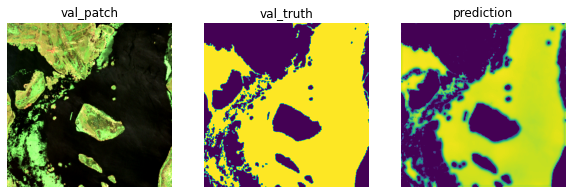

Ep 42/200: traLoss:0.074,traOA:0.974,traMIoU:0.932,valLoss:0.116,valOA:0.964,valMIoU:0.906,time:9.9s
Ep 43/200: traLoss:0.078,traOA:0.971,traMIoU:0.923,valLoss:0.068,valOA:0.979,valMIoU:0.944,time:9.8s
Ep 44/200: traLoss:0.076,traOA:0.972,traMIoU:0.929,valLoss:0.060,valOA:0.981,valMIoU:0.948,time:10.0s
Ep 45/200: traLoss:0.089,traOA:0.967,traMIoU:0.911,valLoss:0.059,valOA:0.984,valMIoU:0.957,time:9.8s
Ep 46/200: traLoss:0.080,traOA:0.969,traMIoU:0.924,valLoss:0.067,valOA:0.980,valMIoU:0.947,time:9.9s
Ep 47/200: traLoss:0.074,traOA:0.972,traMIoU:0.930,valLoss:0.095,valOA:0.968,valMIoU:0.915,time:9.7s
Ep 48/200: traLoss:0.052,traOA:0.981,traMIoU:0.947,valLoss:0.052,valOA:0.984,valMIoU:0.957,time:10.1s
Ep 49/200: traLoss:0.051,traOA:0.982,traMIoU:0.952,valLoss:0.042,valOA:0.986,valMIoU:0.963,time:10.2s
Ep 50/200: traLoss:0.063,traOA:0.977,traMIoU:0.943,valLoss:0.103,valOA:0.972,valMIoU:0.925,time:9.9s
Ep 51/200: traLoss:0.070,traOA:0.973,traMIoU:0.930,valLoss:0.065,valOA:0.979,valMIoU:0.9

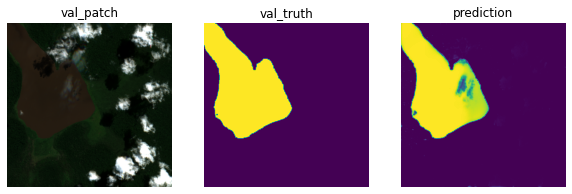

Ep 52/200: traLoss:0.081,traOA:0.971,traMIoU:0.925,valLoss:0.055,valOA:0.982,valMIoU:0.951,time:10.2s
Ep 53/200: traLoss:0.107,traOA:0.960,traMIoU:0.900,valLoss:0.046,valOA:0.983,valMIoU:0.956,time:9.9s
Ep 54/200: traLoss:0.086,traOA:0.967,traMIoU:0.908,valLoss:0.044,valOA:0.983,valMIoU:0.956,time:10.3s
Ep 55/200: traLoss:0.122,traOA:0.953,traMIoU:0.888,valLoss:0.090,valOA:0.971,valMIoU:0.923,time:9.9s
Ep 56/200: traLoss:0.081,traOA:0.973,traMIoU:0.932,valLoss:0.044,valOA:0.985,valMIoU:0.960,time:10.1s
Ep 57/200: traLoss:0.068,traOA:0.977,traMIoU:0.938,valLoss:0.054,valOA:0.981,valMIoU:0.950,time:9.9s
Ep 58/200: traLoss:0.090,traOA:0.964,traMIoU:0.907,valLoss:0.136,valOA:0.955,valMIoU:0.877,time:9.6s
Ep 59/200: traLoss:0.079,traOA:0.969,traMIoU:0.920,valLoss:0.194,valOA:0.960,valMIoU:0.892,time:9.8s
Ep 60/200: traLoss:0.062,traOA:0.977,traMIoU:0.941,valLoss:0.055,valOA:0.982,valMIoU:0.950,time:9.7s
Ep 61/200: traLoss:0.055,traOA:0.981,traMIoU:0.949,valLoss:0.040,valOA:0.985,valMIoU:0.9

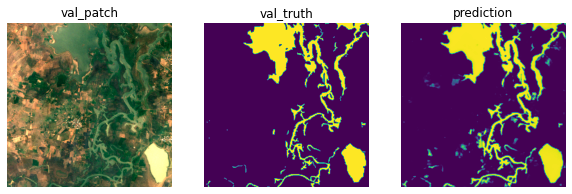

Ep 62/200: traLoss:0.074,traOA:0.972,traMIoU:0.929,valLoss:0.039,valOA:0.985,valMIoU:0.961,time:9.9s
Ep 63/200: traLoss:0.065,traOA:0.976,traMIoU:0.937,valLoss:0.040,valOA:0.986,valMIoU:0.962,time:9.9s
Ep 64/200: traLoss:0.096,traOA:0.964,traMIoU:0.910,valLoss:0.050,valOA:0.986,valMIoU:0.963,time:9.9s
Ep 65/200: traLoss:0.069,traOA:0.977,traMIoU:0.938,valLoss:0.044,valOA:0.983,valMIoU:0.956,time:10.0s
Ep 66/200: traLoss:0.082,traOA:0.974,traMIoU:0.934,valLoss:0.059,valOA:0.980,valMIoU:0.947,time:9.9s
Ep 67/200: traLoss:0.082,traOA:0.968,traMIoU:0.916,valLoss:0.073,valOA:0.972,valMIoU:0.929,time:10.0s
Ep 68/200: traLoss:0.089,traOA:0.967,traMIoU:0.913,valLoss:0.066,valOA:0.981,valMIoU:0.950,time:10.1s
Ep 69/200: traLoss:0.084,traOA:0.966,traMIoU:0.909,valLoss:0.064,valOA:0.979,valMIoU:0.946,time:10.3s
Ep 70/200: traLoss:0.081,traOA:0.971,traMIoU:0.925,valLoss:0.138,valOA:0.937,valMIoU:0.833,time:10.4s
Ep 71/200: traLoss:0.068,traOA:0.977,traMIoU:0.939,valLoss:0.101,valOA:0.959,valMIoU:0

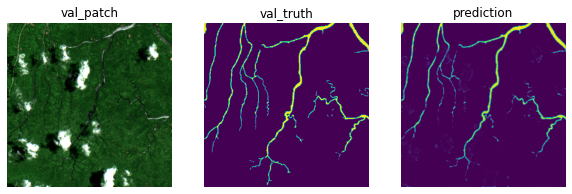

Ep 72/200: traLoss:0.062,traOA:0.976,traMIoU:0.937,valLoss:0.065,valOA:0.981,valMIoU:0.948,time:10.2s
Ep 73/200: traLoss:0.061,traOA:0.977,traMIoU:0.939,valLoss:0.041,valOA:0.986,valMIoU:0.962,time:10.2s
Ep 74/200: traLoss:0.060,traOA:0.977,traMIoU:0.941,valLoss:0.062,valOA:0.979,valMIoU:0.944,time:9.8s
Ep 75/200: traLoss:0.055,traOA:0.980,traMIoU:0.951,valLoss:0.044,valOA:0.986,valMIoU:0.962,time:9.9s
Ep 76/200: traLoss:0.056,traOA:0.979,traMIoU:0.946,valLoss:0.085,valOA:0.969,valMIoU:0.917,time:10.2s
Ep 77/200: traLoss:0.056,traOA:0.979,traMIoU:0.944,valLoss:0.092,valOA:0.975,valMIoU:0.931,time:9.9s
Ep 78/200: traLoss:0.052,traOA:0.980,traMIoU:0.947,valLoss:0.080,valOA:0.974,valMIoU:0.931,time:10.0s
Ep 79/200: traLoss:0.056,traOA:0.979,traMIoU:0.943,valLoss:0.039,valOA:0.986,valMIoU:0.963,time:10.1s
Ep 80/200: traLoss:0.052,traOA:0.981,traMIoU:0.950,valLoss:0.037,valOA:0.988,valMIoU:0.967,time:9.9s
Ep 81/200: traLoss:0.055,traOA:0.980,traMIoU:0.950,valLoss:0.042,valOA:0.986,valMIoU:0

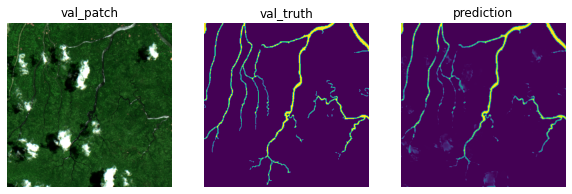

Ep 82/200: traLoss:0.053,traOA:0.980,traMIoU:0.950,valLoss:0.045,valOA:0.983,valMIoU:0.955,time:10.5s
Ep 83/200: traLoss:0.051,traOA:0.981,traMIoU:0.947,valLoss:0.035,valOA:0.988,valMIoU:0.968,time:9.9s
Ep 84/200: traLoss:0.060,traOA:0.979,traMIoU:0.942,valLoss:0.072,valOA:0.980,valMIoU:0.947,time:9.8s
Ep 85/200: traLoss:0.055,traOA:0.979,traMIoU:0.946,valLoss:0.034,valOA:0.988,valMIoU:0.968,time:9.6s
Ep 86/200: traLoss:0.052,traOA:0.981,traMIoU:0.952,valLoss:0.034,valOA:0.988,valMIoU:0.969,time:10.2s
Ep 87/200: traLoss:0.055,traOA:0.980,traMIoU:0.944,valLoss:0.050,valOA:0.982,valMIoU:0.953,time:10.0s
Ep 88/200: traLoss:0.058,traOA:0.979,traMIoU:0.945,valLoss:0.048,valOA:0.984,valMIoU:0.957,time:10.2s
Ep 89/200: traLoss:0.050,traOA:0.981,traMIoU:0.949,valLoss:0.053,valOA:0.982,valMIoU:0.952,time:10.1s
Ep 90/200: traLoss:0.055,traOA:0.978,traMIoU:0.946,valLoss:0.034,valOA:0.988,valMIoU:0.967,time:10.0s
Ep 91/200: traLoss:0.051,traOA:0.981,traMIoU:0.948,valLoss:0.052,valOA:0.984,valMIoU:

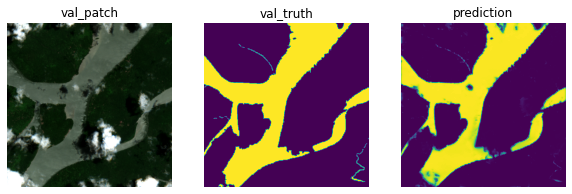

Ep 92/200: traLoss:0.048,traOA:0.983,traMIoU:0.955,valLoss:0.053,valOA:0.984,valMIoU:0.956,time:9.9s
Ep 93/200: traLoss:0.045,traOA:0.983,traMIoU:0.955,valLoss:0.034,valOA:0.988,valMIoU:0.967,time:9.9s
Ep 94/200: traLoss:0.039,traOA:0.985,traMIoU:0.962,valLoss:0.036,valOA:0.987,valMIoU:0.965,time:10.0s
Ep 95/200: traLoss:0.043,traOA:0.984,traMIoU:0.959,valLoss:0.054,valOA:0.979,valMIoU:0.944,time:10.1s
Ep 96/200: traLoss:0.046,traOA:0.984,traMIoU:0.957,valLoss:0.090,valOA:0.960,valMIoU:0.892,time:10.1s
Ep 97/200: traLoss:0.046,traOA:0.982,traMIoU:0.952,valLoss:0.076,valOA:0.965,valMIoU:0.907,time:9.9s
Ep 98/200: traLoss:0.050,traOA:0.982,traMIoU:0.952,valLoss:0.043,valOA:0.985,valMIoU:0.961,time:10.1s
Ep 99/200: traLoss:0.046,traOA:0.983,traMIoU:0.956,valLoss:0.033,valOA:0.989,valMIoU:0.971,time:9.8s
Ep 100/200: traLoss:0.050,traOA:0.982,traMIoU:0.949,valLoss:0.037,valOA:0.988,valMIoU:0.967,time:10.1s
Ep 101/200: traLoss:0.064,traOA:0.977,traMIoU:0.938,valLoss:0.040,valOA:0.987,valMIoU

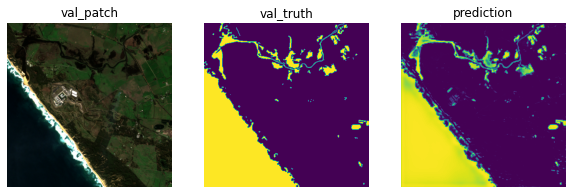

Ep 102/200: traLoss:0.080,traOA:0.973,traMIoU:0.927,valLoss:0.057,valOA:0.985,valMIoU:0.960,time:10.1s
Ep 103/200: traLoss:0.081,traOA:0.969,traMIoU:0.916,valLoss:0.162,valOA:0.927,valMIoU:0.810,time:10.0s
Ep 104/200: traLoss:0.063,traOA:0.979,traMIoU:0.942,valLoss:0.051,valOA:0.982,valMIoU:0.951,time:10.0s
Ep 105/200: traLoss:0.050,traOA:0.982,traMIoU:0.951,valLoss:0.047,valOA:0.984,valMIoU:0.958,time:10.0s
Ep 106/200: traLoss:0.052,traOA:0.981,traMIoU:0.952,valLoss:0.037,valOA:0.987,valMIoU:0.965,time:9.9s
Ep 107/200: traLoss:0.058,traOA:0.978,traMIoU:0.943,valLoss:0.032,valOA:0.989,valMIoU:0.970,time:10.2s
Ep 108/200: traLoss:0.057,traOA:0.978,traMIoU:0.945,valLoss:0.038,valOA:0.986,valMIoU:0.963,time:9.9s
Ep 109/200: traLoss:0.057,traOA:0.977,traMIoU:0.943,valLoss:0.046,valOA:0.984,valMIoU:0.956,time:10.0s
Ep 110/200: traLoss:0.063,traOA:0.977,traMIoU:0.938,valLoss:0.066,valOA:0.978,valMIoU:0.940,time:9.9s
Ep 111/200: traLoss:0.049,traOA:0.982,traMIoU:0.955,valLoss:0.036,valOA:0.98

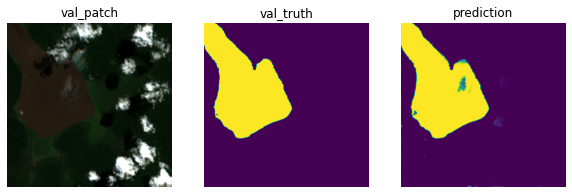

Ep 112/200: traLoss:0.053,traOA:0.980,traMIoU:0.945,valLoss:0.035,valOA:0.987,valMIoU:0.966,time:10.1s
Ep 113/200: traLoss:0.046,traOA:0.984,traMIoU:0.958,valLoss:0.036,valOA:0.988,valMIoU:0.967,time:9.9s
Ep 114/200: traLoss:0.055,traOA:0.979,traMIoU:0.945,valLoss:0.051,valOA:0.986,valMIoU:0.963,time:10.1s
Ep 115/200: traLoss:0.049,traOA:0.982,traMIoU:0.950,valLoss:0.040,valOA:0.988,valMIoU:0.969,time:10.2s
Ep 116/200: traLoss:0.044,traOA:0.983,traMIoU:0.954,valLoss:0.041,valOA:0.986,valMIoU:0.963,time:10.0s
Ep 117/200: traLoss:0.048,traOA:0.982,traMIoU:0.950,valLoss:0.039,valOA:0.986,valMIoU:0.963,time:9.9s
Ep 118/200: traLoss:0.046,traOA:0.983,traMIoU:0.954,valLoss:0.037,valOA:0.987,valMIoU:0.966,time:9.8s
Ep 119/200: traLoss:0.055,traOA:0.979,traMIoU:0.948,valLoss:0.062,valOA:0.975,valMIoU:0.933,time:9.9s
Ep 120/200: traLoss:0.048,traOA:0.982,traMIoU:0.951,valLoss:0.030,valOA:0.989,valMIoU:0.970,time:9.9s
Ep 121/200: traLoss:0.048,traOA:0.982,traMIoU:0.952,valLoss:0.054,valOA:0.983,

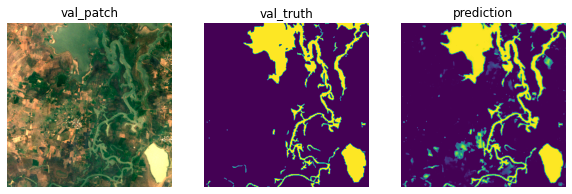

Ep 122/200: traLoss:0.044,traOA:0.984,traMIoU:0.957,valLoss:0.050,valOA:0.985,valMIoU:0.959,time:10.1s
Ep 123/200: traLoss:0.046,traOA:0.984,traMIoU:0.955,valLoss:0.060,valOA:0.982,valMIoU:0.953,time:9.9s
Ep 124/200: traLoss:0.053,traOA:0.981,traMIoU:0.948,valLoss:0.051,valOA:0.984,valMIoU:0.956,time:10.1s
Ep 125/200: traLoss:0.050,traOA:0.981,traMIoU:0.950,valLoss:0.031,valOA:0.989,valMIoU:0.970,time:9.7s
Ep 126/200: traLoss:0.067,traOA:0.979,traMIoU:0.947,valLoss:0.034,valOA:0.988,valMIoU:0.967,time:9.9s
Ep 127/200: traLoss:0.044,traOA:0.983,traMIoU:0.957,valLoss:0.036,valOA:0.988,valMIoU:0.969,time:10.1s
Ep 128/200: traLoss:0.057,traOA:0.979,traMIoU:0.944,valLoss:0.037,valOA:0.987,valMIoU:0.965,time:10.1s
Ep 129/200: traLoss:0.046,traOA:0.983,traMIoU:0.955,valLoss:0.032,valOA:0.989,valMIoU:0.969,time:10.0s
Ep 130/200: traLoss:0.046,traOA:0.983,traMIoU:0.954,valLoss:0.035,valOA:0.989,valMIoU:0.970,time:10.0s
Ep 131/200: traLoss:0.050,traOA:0.982,traMIoU:0.952,valLoss:0.041,valOA:0.98

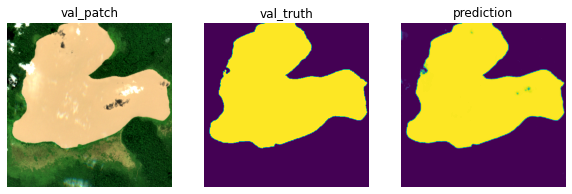

Ep 132/200: traLoss:0.045,traOA:0.984,traMIoU:0.955,valLoss:0.032,valOA:0.989,valMIoU:0.971,time:10.0s
Ep 133/200: traLoss:0.046,traOA:0.984,traMIoU:0.957,valLoss:0.115,valOA:0.953,valMIoU:0.874,time:10.1s
Ep 134/200: traLoss:0.040,traOA:0.985,traMIoU:0.961,valLoss:0.039,valOA:0.987,valMIoU:0.965,time:10.3s
Ep 135/200: traLoss:0.043,traOA:0.984,traMIoU:0.957,valLoss:0.033,valOA:0.988,valMIoU:0.968,time:9.9s
Ep 136/200: traLoss:0.043,traOA:0.984,traMIoU:0.954,valLoss:0.030,valOA:0.989,valMIoU:0.971,time:10.0s
Ep 137/200: traLoss:0.045,traOA:0.983,traMIoU:0.955,valLoss:0.029,valOA:0.990,valMIoU:0.972,time:10.0s
Ep 138/200: traLoss:0.042,traOA:0.984,traMIoU:0.957,valLoss:0.032,valOA:0.989,valMIoU:0.969,time:10.1s
Ep 139/200: traLoss:0.039,traOA:0.985,traMIoU:0.960,valLoss:0.029,valOA:0.990,valMIoU:0.972,time:10.0s
Ep 140/200: traLoss:0.043,traOA:0.984,traMIoU:0.957,valLoss:0.034,valOA:0.988,valMIoU:0.967,time:9.8s
Ep 141/200: traLoss:0.038,traOA:0.986,traMIoU:0.963,valLoss:0.029,valOA:0.9

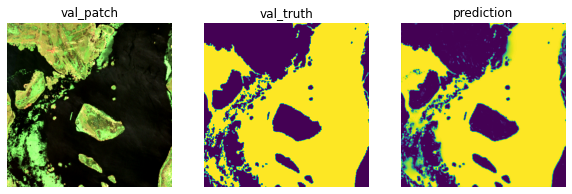

Ep 142/200: traLoss:0.042,traOA:0.985,traMIoU:0.959,valLoss:0.039,valOA:0.986,valMIoU:0.963,time:10.2s
Ep 143/200: traLoss:0.039,traOA:0.986,traMIoU:0.962,valLoss:0.034,valOA:0.988,valMIoU:0.968,time:9.9s
Ep 144/200: traLoss:0.040,traOA:0.985,traMIoU:0.960,valLoss:0.032,valOA:0.989,valMIoU:0.970,time:10.1s
Ep 145/200: traLoss:0.040,traOA:0.985,traMIoU:0.961,valLoss:0.029,valOA:0.989,valMIoU:0.971,time:10.1s
Ep 146/200: traLoss:0.044,traOA:0.984,traMIoU:0.958,valLoss:0.028,valOA:0.990,valMIoU:0.972,time:10.2s
Ep 147/200: traLoss:0.044,traOA:0.983,traMIoU:0.955,valLoss:0.030,valOA:0.989,valMIoU:0.971,time:9.9s
Ep 148/200: traLoss:0.057,traOA:0.980,traMIoU:0.951,valLoss:0.041,valOA:0.987,valMIoU:0.965,time:10.4s
Ep 149/200: traLoss:0.042,traOA:0.984,traMIoU:0.958,valLoss:0.032,valOA:0.989,valMIoU:0.970,time:10.0s
Ep 150/200: traLoss:0.041,traOA:0.985,traMIoU:0.961,valLoss:0.032,valOA:0.989,valMIoU:0.970,time:10.1s
Ep 151/200: traLoss:0.046,traOA:0.982,traMIoU:0.954,valLoss:0.033,valOA:0.9

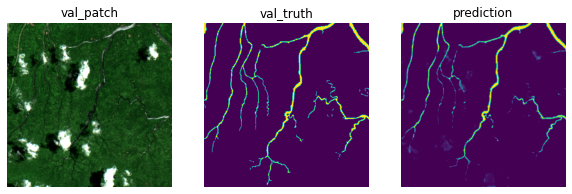

Ep 152/200: traLoss:0.042,traOA:0.984,traMIoU:0.959,valLoss:0.040,valOA:0.987,valMIoU:0.964,time:10.1s
Ep 153/200: traLoss:0.043,traOA:0.984,traMIoU:0.959,valLoss:0.034,valOA:0.988,valMIoU:0.967,time:10.1s
Ep 154/200: traLoss:0.041,traOA:0.984,traMIoU:0.956,valLoss:0.031,valOA:0.988,valMIoU:0.969,time:10.2s
Ep 155/200: traLoss:0.040,traOA:0.985,traMIoU:0.960,valLoss:0.027,valOA:0.990,valMIoU:0.973,time:10.2s
Ep 156/200: traLoss:0.045,traOA:0.984,traMIoU:0.957,valLoss:0.035,valOA:0.987,valMIoU:0.965,time:10.0s
Ep 157/200: traLoss:0.048,traOA:0.981,traMIoU:0.948,valLoss:0.032,valOA:0.989,valMIoU:0.969,time:10.2s
Ep 158/200: traLoss:0.044,traOA:0.983,traMIoU:0.955,valLoss:0.029,valOA:0.989,valMIoU:0.970,time:10.0s
Ep 159/200: traLoss:0.040,traOA:0.985,traMIoU:0.959,valLoss:0.027,valOA:0.990,valMIoU:0.972,time:10.1s
Ep 160/200: traLoss:0.042,traOA:0.984,traMIoU:0.958,valLoss:0.035,valOA:0.989,valMIoU:0.971,time:10.0s
Ep 161/200: traLoss:0.044,traOA:0.983,traMIoU:0.955,valLoss:0.028,valOA:0

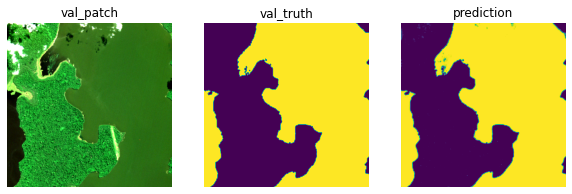

Ep 162/200: traLoss:0.037,traOA:0.986,traMIoU:0.961,valLoss:0.033,valOA:0.989,valMIoU:0.971,time:9.9s
Ep 163/200: traLoss:0.041,traOA:0.984,traMIoU:0.956,valLoss:0.028,valOA:0.990,valMIoU:0.973,time:10.0s
Ep 164/200: traLoss:0.042,traOA:0.985,traMIoU:0.961,valLoss:0.029,valOA:0.990,valMIoU:0.972,time:9.9s
Ep 165/200: traLoss:0.038,traOA:0.985,traMIoU:0.962,valLoss:0.030,valOA:0.989,valMIoU:0.970,time:9.8s
Ep 166/200: traLoss:0.037,traOA:0.986,traMIoU:0.962,valLoss:0.029,valOA:0.989,valMIoU:0.971,time:10.0s
Ep 167/200: traLoss:0.037,traOA:0.986,traMIoU:0.961,valLoss:0.028,valOA:0.989,valMIoU:0.972,time:10.0s
Ep 168/200: traLoss:0.049,traOA:0.982,traMIoU:0.953,valLoss:0.031,valOA:0.989,valMIoU:0.970,time:10.0s
Ep 169/200: traLoss:0.045,traOA:0.983,traMIoU:0.955,valLoss:0.030,valOA:0.989,valMIoU:0.971,time:10.1s
Ep 170/200: traLoss:0.040,traOA:0.985,traMIoU:0.959,valLoss:0.030,valOA:0.989,valMIoU:0.971,time:9.8s
Ep 171/200: traLoss:0.038,traOA:0.986,traMIoU:0.962,valLoss:0.030,valOA:0.989

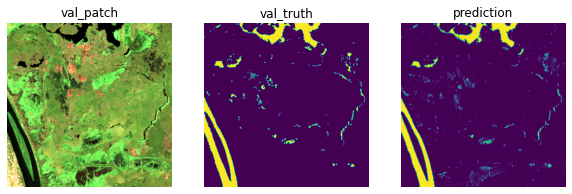

Ep 172/200: traLoss:0.039,traOA:0.985,traMIoU:0.964,valLoss:0.030,valOA:0.989,valMIoU:0.971,time:10.0s
Ep 173/200: traLoss:0.039,traOA:0.986,traMIoU:0.961,valLoss:0.031,valOA:0.989,valMIoU:0.971,time:9.9s
Ep 174/200: traLoss:0.043,traOA:0.983,traMIoU:0.952,valLoss:0.029,valOA:0.989,valMIoU:0.972,time:9.9s
Ep 175/200: traLoss:0.047,traOA:0.983,traMIoU:0.957,valLoss:0.030,valOA:0.989,valMIoU:0.970,time:9.5s
Ep 176/200: traLoss:0.037,traOA:0.986,traMIoU:0.964,valLoss:0.033,valOA:0.988,valMIoU:0.969,time:9.9s
Ep 177/200: traLoss:0.039,traOA:0.985,traMIoU:0.959,valLoss:0.028,valOA:0.990,valMIoU:0.972,time:9.9s
Ep 178/200: traLoss:0.040,traOA:0.985,traMIoU:0.960,valLoss:0.027,valOA:0.990,valMIoU:0.973,time:10.1s
Ep 179/200: traLoss:0.039,traOA:0.985,traMIoU:0.961,valLoss:0.028,valOA:0.990,valMIoU:0.973,time:9.7s
Ep 180/200: traLoss:0.038,traOA:0.986,traMIoU:0.963,valLoss:0.029,valOA:0.990,valMIoU:0.972,time:9.9s
Ep 181/200: traLoss:0.036,traOA:0.986,traMIoU:0.964,valLoss:0.028,valOA:0.990,va

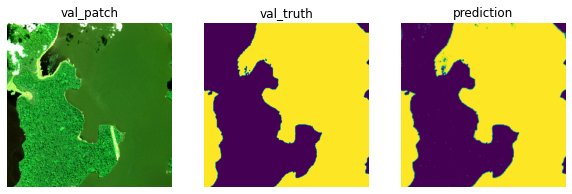

Ep 182/200: traLoss:0.037,traOA:0.986,traMIoU:0.959,valLoss:0.026,valOA:0.990,valMIoU:0.974,time:9.9s
Ep 183/200: traLoss:0.037,traOA:0.986,traMIoU:0.964,valLoss:0.029,valOA:0.989,valMIoU:0.971,time:9.8s
Ep 184/200: traLoss:0.035,traOA:0.987,traMIoU:0.966,valLoss:0.029,valOA:0.989,valMIoU:0.971,time:10.0s
Ep 185/200: traLoss:0.038,traOA:0.986,traMIoU:0.961,valLoss:0.028,valOA:0.990,valMIoU:0.972,time:10.2s
Ep 186/200: traLoss:0.043,traOA:0.984,traMIoU:0.956,valLoss:0.030,valOA:0.990,valMIoU:0.972,time:10.0s
Ep 187/200: traLoss:0.035,traOA:0.986,traMIoU:0.963,valLoss:0.027,valOA:0.990,valMIoU:0.973,time:9.8s
Ep 188/200: traLoss:0.041,traOA:0.985,traMIoU:0.960,valLoss:0.026,valOA:0.990,valMIoU:0.974,time:9.6s
Ep 189/200: traLoss:0.036,traOA:0.986,traMIoU:0.961,valLoss:0.026,valOA:0.990,valMIoU:0.974,time:9.9s
Ep 190/200: traLoss:0.037,traOA:0.986,traMIoU:0.964,valLoss:0.026,valOA:0.990,valMIoU:0.974,time:9.9s
Ep 191/200: traLoss:0.036,traOA:0.987,traMIoU:0.963,valLoss:0.026,valOA:0.990,v

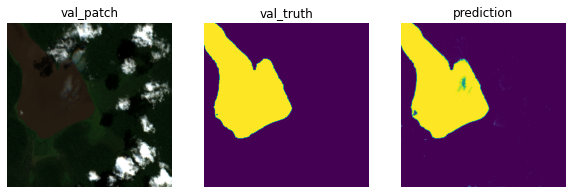

Ep 192/200: traLoss:0.038,traOA:0.986,traMIoU:0.963,valLoss:0.026,valOA:0.990,valMIoU:0.974,time:10.1s
Ep 193/200: traLoss:0.037,traOA:0.986,traMIoU:0.963,valLoss:0.026,valOA:0.990,valMIoU:0.974,time:9.9s
Ep 194/200: traLoss:0.042,traOA:0.984,traMIoU:0.958,valLoss:0.027,valOA:0.990,valMIoU:0.974,time:9.6s
Ep 195/200: traLoss:0.037,traOA:0.986,traMIoU:0.962,valLoss:0.026,valOA:0.990,valMIoU:0.974,time:9.7s
Ep 196/200: traLoss:0.034,traOA:0.987,traMIoU:0.965,valLoss:0.026,valOA:0.990,valMIoU:0.974,time:9.9s
Ep 197/200: traLoss:0.033,traOA:0.987,traMIoU:0.967,valLoss:0.026,valOA:0.990,valMIoU:0.974,time:10.0s
Ep 198/200: traLoss:0.035,traOA:0.987,traMIoU:0.966,valLoss:0.026,valOA:0.990,valMIoU:0.974,time:9.9s
Ep 199/200: traLoss:0.037,traOA:0.986,traMIoU:0.963,valLoss:0.026,valOA:0.990,valMIoU:0.974,time:9.9s
Ep 200/200: traLoss:0.040,traOA:0.986,traMIoU:0.959,valLoss:0.026,valOA:0.990,valMIoU:0.974,time:9.9s


In [7]:
## training
with tf.device('/device:GPU:1'):
    miou_plot, loss_plot =train_loops(model=model, \
                        loss_fun=config.loss_bce, \
                        optimizer=config.opt_adam, \
                        tra_dset=tra_dset, \
                        val_dset=val_dset, \
                        epochs=config.epochs,
                        )


In [8]:
# ## saving metric
# metric_path = "result/metrics_watnet.csv"
# dataframe = pd.DataFrame({'val_miou':miou_plot, 'val_loss':loss_plot})
# dataframe.to_csv(metric_path, index=False, sep=',')


In [8]:
# # model saving.h5
# path_save = 'model/pretrained/watnet.h5'
# path_save = 'model/pretrained/deepwatermapv2.h5'
# path_save = 'model/pretrained/deeplabv3plus.h5'
# model.save(path_save)
